<a href="https://colab.research.google.com/github/glf58/Covid_classification/blob/main/GradCamPremierModele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import tensorflow as tf

from skimage import exposure
import matplotlib.cm as cm

from google.colab import drive
from zipfile import ZipFile

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Reshape
from tensorflow.keras.models import Model, load_model

print(tf.__version__)

2.8.2


In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
path_out = '/content' #chemin dans l'env. colab ou on va copier les data de test supplementaires
path_drive = '/content/drive/MyDrive/kaggle'   # chemin de l'archive qui contient le fichier kaggle.json necessaire pour telecharger les donnees

#on telecharge les donnees depuis kaggle
if not os.path.exists('/content/kaggle'):
  os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"
  os.mkdir(os.path.join(path_out, 'kaggle'))
  shutil.copy(os.path.join(path_drive, 'kaggle.json'), os.path.join(path_out, 'kaggle', 'kaggle.json'))

!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

#on dezippe les donnees dans le repertoire path_out
archive = '/content/covid19-radiography-database.zip'
with ZipFile(archive, 'r') as zip_ref:
  zip_ref.extractall(path_out)


 98% 766M/778M [00:04<00:00, 198MB/s]
100% 778M/778M [00:04<00:00, 167MB/s]


In [4]:
IMG_SIZE = 299

def preprocess (img_path, mask_path, contraste, poumon):  
  
  #on charge l'image originale
  img = tf.io.read_file(img_path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='nearest')
  if contraste=='equalized':
    #on normalise les histogrammes et on ecrase l'image precedente
    array = np.squeeze(img.numpy(),-1)
    img = exposure.equalize_adapthist(array, clip_limit=0.03)
    #apres cette etape, l'image est de taille 299x299 et les pixels sont entre 0 et 1. On remet l'image au format attendu pour la suite des traitements (299,299,1) et pixels entre 0 et 255
    img = np.expand_dims(img, -1)
    img *= 255.
  if poumon =='image_initiale':
    return tf.cast(img, tf.float32)/255.0
  else:
    #on charge le masque
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method='nearest')
    if poumon=='poumon_only':
      masked_img = tf.bitwise.bitwise_and(img, mask)
    elif poumon=='poumon_cache':
      masked_img = tf.bitwise.bitwise_or(img, mask)
    else:
      print("probleme avec poumon")
      exit()
    return tf.cast(masked_img, tf.float32)/255.0
    


In [99]:
def gradcam (img_path, mask_path, contraste, poumon, model):

  dict_layers = {v:i for (i, v) in enumerate(model.layers)}
  conv_layers = [layer for layer in model.layers if "conv2d" in layer.name]
  last_conv_layer = conv_layers[-1]
  last_conv_layer_idx = dict_layers[last_conv_layer]
  #print(last_conv_layer, last_conv_layer_idx)
  last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

  classifier_input = Input(shape = last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer in model.layers[last_conv_layer_idx+1:]:
    x = layer (x)
  classifier_model = Model(classifier_input, x)

  img_res = preprocess(img_path, mask_path, contraste, poumon)
  #print('image originale', img_res.shape, np.max(img_res), np.min(img_res))
#  fig=plt.figure(figsize=(10,5))
#  plt.subplot(121)
#  plt.title('image originale: COVID-'+str(idx))
#  plt.imshow(np.squeeze(img_res, axis=-1), cmap='gray')
#  plt.axis('off')
  img_tf = tf.expand_dims(img_res, 0)
  img_tf = tf.expand_dims(img_tf, 0)

  with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_tf)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    #print(preds)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
  #print('grads ', grads.shape, pooled_grads.shape, np.min(pooled_grads), np.max(pooled_grads))
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  #print('last_conv_layer_output_numpy', last_conv_layer_output.shape)
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:,:,i] *= pooled_grads[i]

  
  heatmap = np.mean(last_conv_layer_output, axis=-1)
  #print('heatmap', np.min(heatmap), np.max(heatmap), np.mean(heatmap))
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = np.uint8(255*heatmap)
  #print(heatmap.shape, np.min(heatmap), np.max(heatmap), np.mean(heatmap))
  
  img = tf.keras.utils.load_img(img_path, color_mode='rgb', target_size=(IMG_SIZE, IMG_SIZE))
  img = tf.keras.utils.img_to_array(img) / 255.
  if poumon=='poumon_only':
    mask = tf.keras.utils.load_img(mask_path, color_mode='rgb', target_size=(IMG_SIZE, IMG_SIZE))
    mask = tf.keras.utils.img_to_array(mask) / 255.
    img = img * mask
  elif poumon=='poumon_cache':
    mask = tf.keras.utils.load_img(mask_path, target_size=(IMG_SIZE, IMG_SIZE))
    mask = tf.keras.utils.img_to_array(mask) / 255.
    img = img * (1 - mask)

  jet = cm.get_cmap("jet")
  jet_colors = jet(np.arange(256))[:,:3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
  superimposed_img = jet_heatmap * 0.4 + img * 255
  superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

  #plt.subplot(122)
  #plt.title('classe predite:'+str(top_pred_index.numpy()))
  #plt.imshow(superimposed_img)
  #plt.axis('off')

  return (img_res, superimposed_img, top_pred_index.numpy())

In [29]:
contrastes = ['equalized', 'initial']
poumons = ['image_initiale', 'poumon_only', 'poumon_cache']

poumon = poumons[0]
contraste = contrastes[1]
name_model = 'Lenet_'+poumon+'_'+contraste
mod_poumon_cache = load_model('/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/Lenet_poumon_cache_initial')
mod_poumon_only = load_model('/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/Lenet_poumon_only_initial')
mod_image_initiale = load_model('/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/Lenet_image_initiale_initial')

on charge le modele:  Lenet_image_initiale_initial


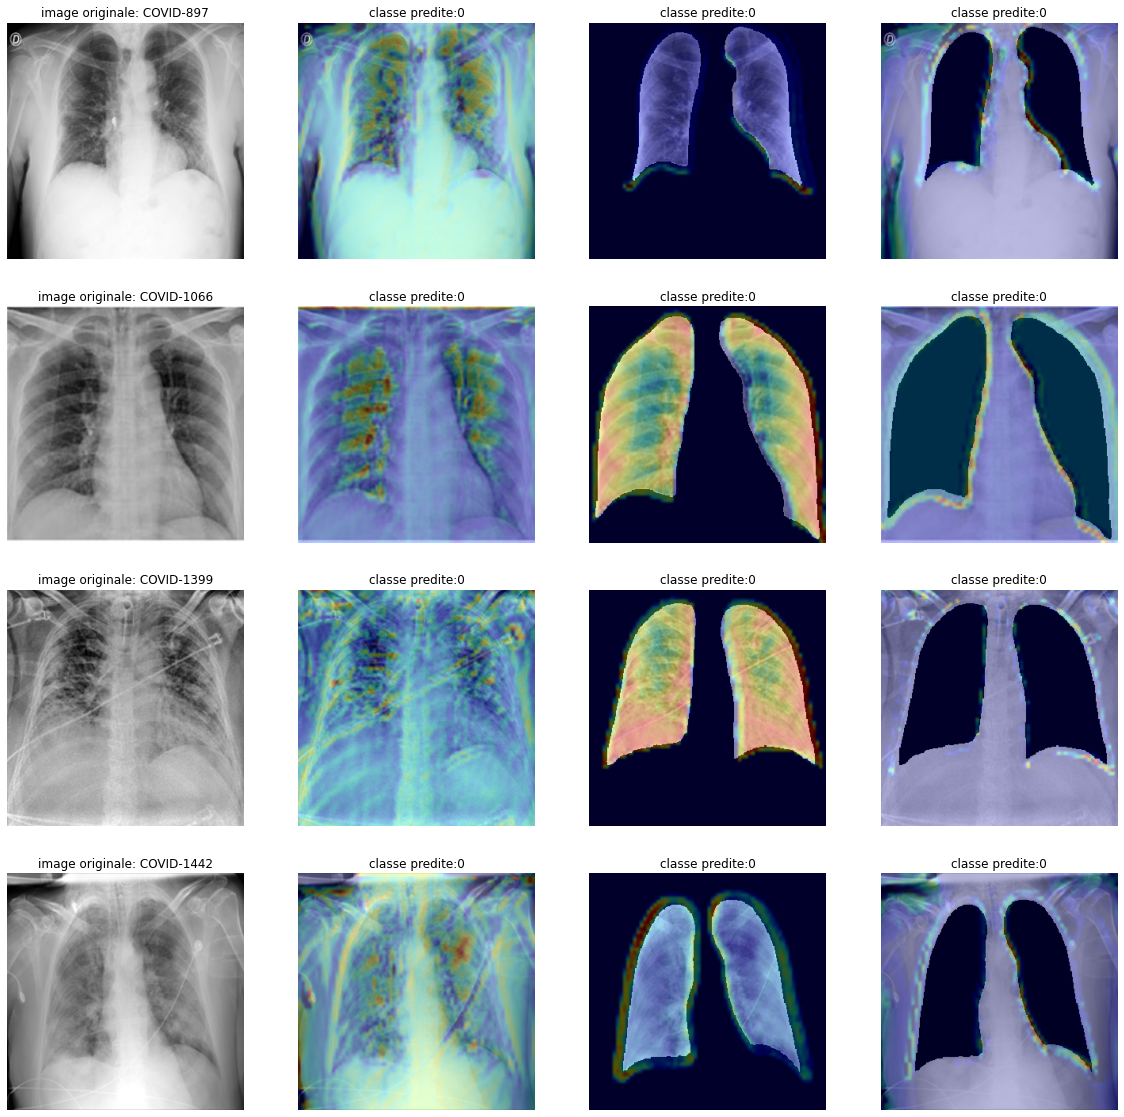

In [128]:
n_imgs = 4
liste_idx = np.random.randint(1,1899, size=n_imgs)
liste_idx = [897, 1066, 1399, 1442]
fig, axs = plt.subplots(n_imgs, 4, figsize=(20, 20))

for i, idx in enumerate(liste_idx):
  img_path, mask_path = '/content/COVID-19_Radiography_Dataset/COVID/images/COVID-'+str(idx)+'.png','/content/COVID-19_Radiography_Dataset/COVID/masks/COVID-'+str(idx)+'.png' 

  img_poumon_cache, superimposed_poumon_cache, res_poumon_cache = gradcam(img_path, mask_path, contrastes[1], poumons[2], mod_poumon_cache)
  img_poumon_only, superimposed_poumon_only, res_poumon_only = gradcam(img_path, mask_path, contrastes[1], poumons[1], mod_poumon_only)
  img_initiale, superimposed_img_initiale, res_image_initiale = gradcam(img_path, mask_path, contrastes[1], poumons[0], mod_image_initiale)

  axs[i, 0].set_title('image originale: COVID-'+str(idx))
  axs[i, 0].imshow(np.squeeze(img_initiale, axis=-1), cmap='gray')
  axs[i, 0].set_axis_off()

  axs[i, 1].set_title('classe predite:'+str(res_image_initiale))
  axs[i, 1].imshow(superimposed_img_initiale)
  axs[i, 1].set_axis_off()

  axs[i, 2].set_title('classe predite:'+str(res_poumon_only))
  axs[i, 2].imshow(superimposed_poumon_only)
  axs[i, 2].set_axis_off()
  
  axs[i, 3].set_title('classe predite:'+str(res_poumon_cache))
  axs[i, 3].imshow(superimposed_poumon_cache)
  axs[i, 3].set_axis_off()

if True:
  fig.savefig('/content/drive/MyDrive/Colab Notebooks/covid/results/GradCam-'+str(liste_idx)+'.png')
 